## Motivo de esta parte
Esta parte fue hecha para encontrar el mejor valor de L a utilizar y la cantidad de iteraciones, asi mismo para graficar el accuracy de cada iteración

### Post analisis de los gráficos
Se comprobó que los resultados más estables por encima del 90% eran con L = 0.01 e iteraciones = 100_000 así que estas serán las seleccionadas para la red

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# carga de datos 
all_data = pd.read_csv("Actualizado_DnD5e_Monsters_Stats.csv")
# seleccion de las columnas de entradas (todas menos la última)
all_inputs = all_data.iloc[:, :-1].values
# selecciono la columna de salida (la última)
all_outputs = all_data.iloc[:, -1].values

# División del conjunto de datos en entrenamiento y prueba (1/3 de prueba)
X_train, X_test, Y_train, Y_test = train_test_split(all_inputs, all_outputs, test_size=1/3)
n = X_train.shape[0] # número de registros de entrenamiento


In [29]:
import matplotlib.pyplot as plt

accuracy_train_l = []
accuracy_test_l = []

def graficar_accuracy(L, train_l, test_l):
    iters = len(test_l)
    fmt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3
    }

    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3
    }

    fig, (ax) = plt.subplots(1,1,figsize=(10,8))

    ax.plot(train_l, label='Train', **fmt_train)
    ax.plot(test_l, label='Test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f'Accuracy {L=}')
    ax.set_xlabel('Step')

    fig.tight_layout()
    plt.savefig(f'accuracy\\accuracy_{L=}_{iters=}.png')

In [30]:
def mi_red_neuronal(L,iteraciones):
    np.random.seed(10) #Con una semilla para reproductibilidad
    w_hidden = np.random.rand(4, 8) *2 - 1# hay 4 nodos en la  capa oculta y 8 entradas, cada una con su peso
    w_output = np.random.rand(1, 4) *2 - 1# Hay 1 nodo de salida y 4 entradas de cada uno de los nodos de la capa anterior

    b_hidden = np.random.rand(4, 1) *2 - 1# Al haber 4 nodos, cada uno tiene su propio sesgo
    b_output = np.random.rand(1, 1) *2 - 1# El nodo de salida tiene su propio sesgo

    # Funciones de activacion
    relu = lambda x: np.maximum(x, 0) #Para la capa oculta
    logistic = lambda x: 1 / (1 + np.exp(-x)) #Para la capa de salida


    def forward_prop(X): # Forward propagation con una capa oculta y una capa de salida
        Z1 = w_hidden @ X + b_hidden
        A1 = relu(Z1)
        Z2 = w_output @ A1 + b_output
        A2 = logistic(Z2)
        return Z1, A1, Z2, A2

    #Back propagation

    # Derivadas de las funciones de activación
    d_relu = lambda x: x > 0
    d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    # Cálculo de derivadas para obtener la derivada del costo con respecto a cada elemento
    def backward_prop(Z1, A1, Z2, A2, X, Y):
        # Cálculo de cada parte de la derivada utilizando la regla de la cadena
        dC_dA2 = 2 * A2 - 2 * Y
        dA2_dZ2 = d_logistic(Z2)
        dZ2_dA1 = w_output
        dZ2_dW2 = A1
        dZ2_dB2 = 1
        dA1_dZ1 = d_relu(Z1)
        dZ1_dW1 = X
        dZ1_dB1 = 1

        # Derivadas del costo con respecto a W2, B2, A1, W1 y B1
        dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T

        dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2

        dC_dA1 = dC_dA2 @ dA2_dZ2 @ dZ2_dA1

        dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T

        dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

        return dC_dW1, dC_dB1, dC_dW2, dC_dB2
    
    # Descenso de gradiente estocástico
    accuracy_train_l = []
    accuracy_test_l = []


    for i in tqdm(range(iteraciones)):
        # seleccionar aleatoriamente uno de los datos de entrenamiento
        idx = np.random.choice(n, 1, replace=False) 
        X_sample = X_train[idx].transpose()
        Y_sample = Y_train[idx]

        # pasar datos seleccionados aleatoriamente a través de la red neuronal
        Z1, A1, Z2, A2 = forward_prop(X_sample)

        # distribuir error a través de la retropropagación
        # y devolver pendientes para pesos y sesgos
        dW1, dB1, dW2, dB2 = backward_prop(Z1, A1, Z2, A2, X_sample, Y_sample)

        # actualizar pesos y sesgos
        w_hidden -= L * dW1
        b_hidden -= L * dB1
        w_output -= L * dW2
        b_output -= L * dB2
        
        # Calculo de presisión train
        train_predictions = forward_prop(X_train.transpose())[3]
        train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)
        train_accuracy = sum(train_comparisons.astype(int)) / X_train.shape[0]
        accuracy_train_l.append(train_accuracy)

        # Calculo de precisión de prueba
        test_predictions = forward_prop(X_test.transpose())[3]  
        test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
        test_accuracy = sum(test_comparisons.astype(int)) / X_test.shape[0]
        accuracy_test_l.append(test_accuracy)
        
    graficar_accuracy(L=L, train_l=accuracy_train_l,test_l=accuracy_test_l)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/30000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

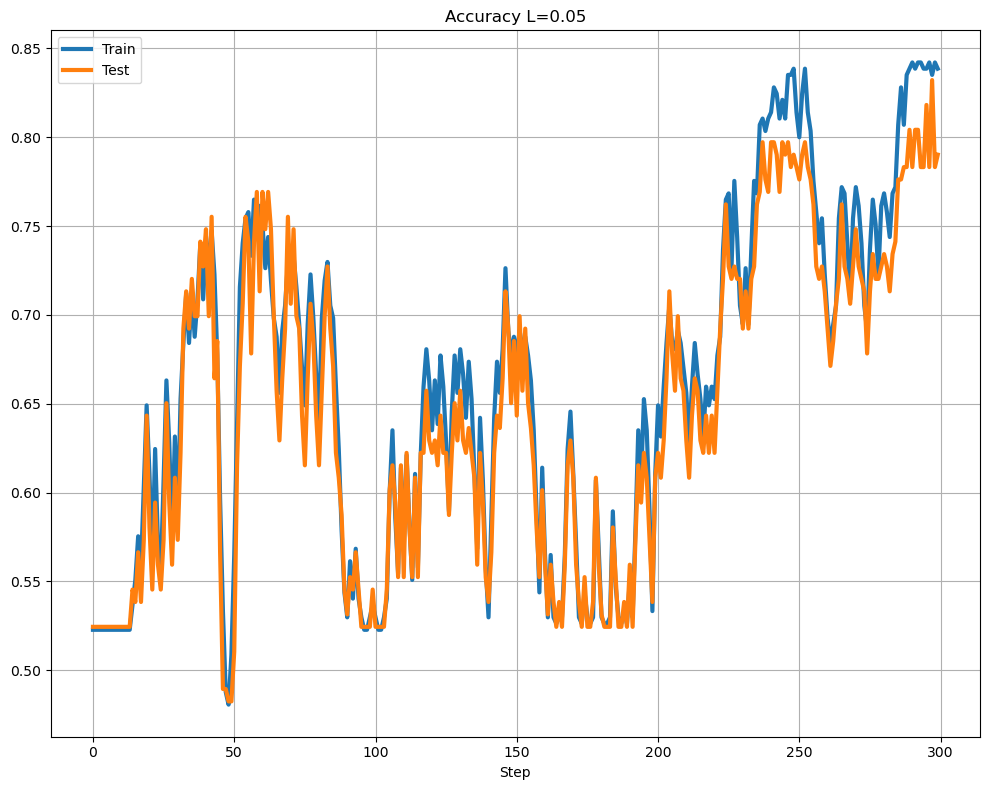

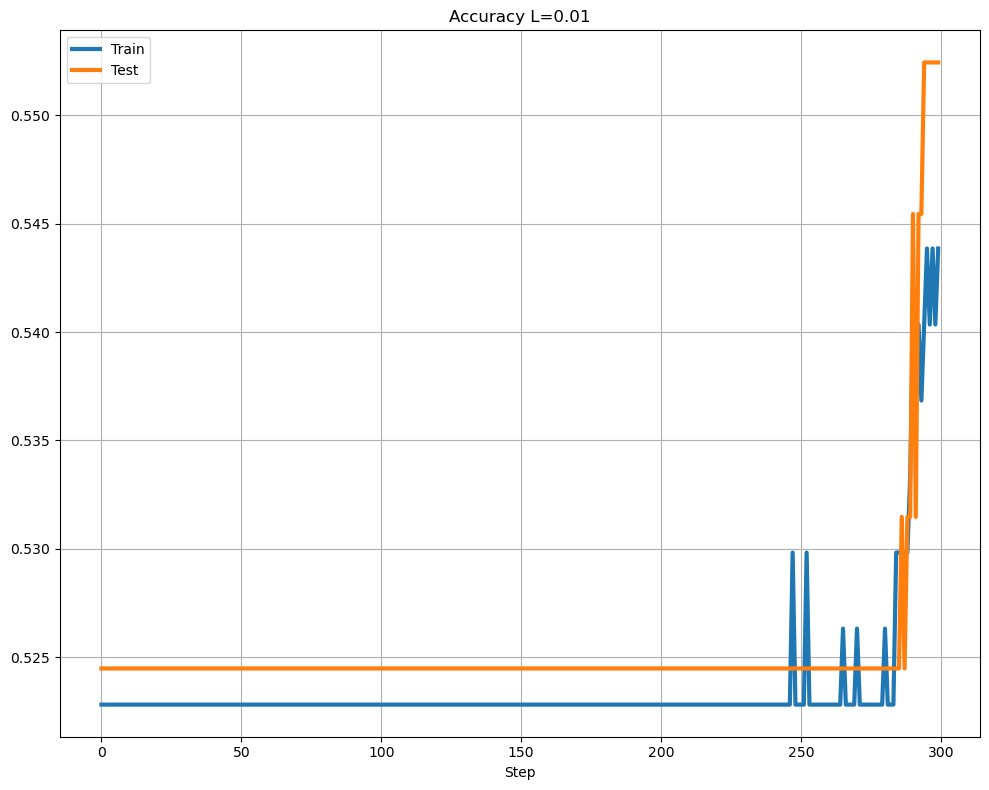

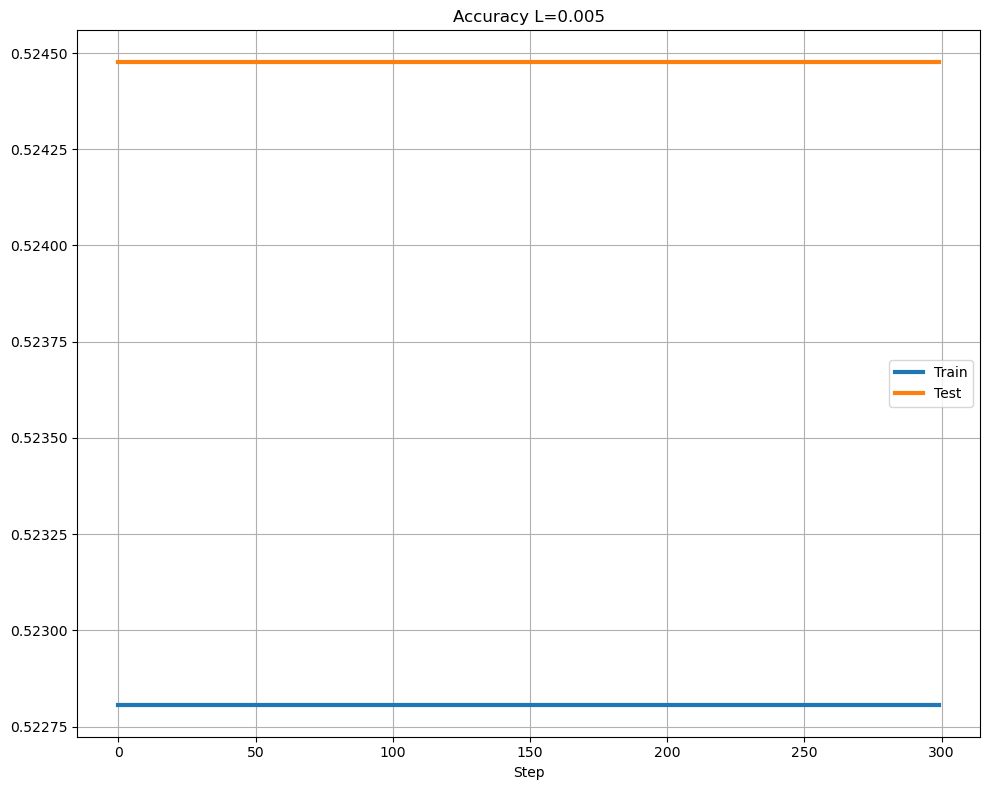

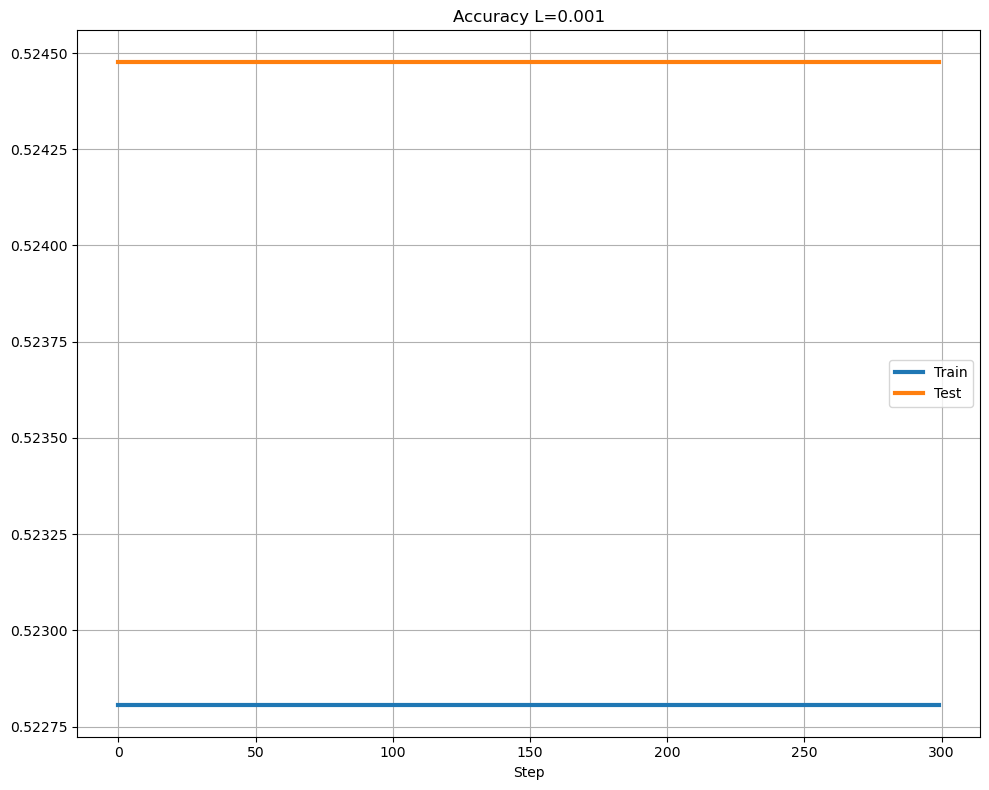

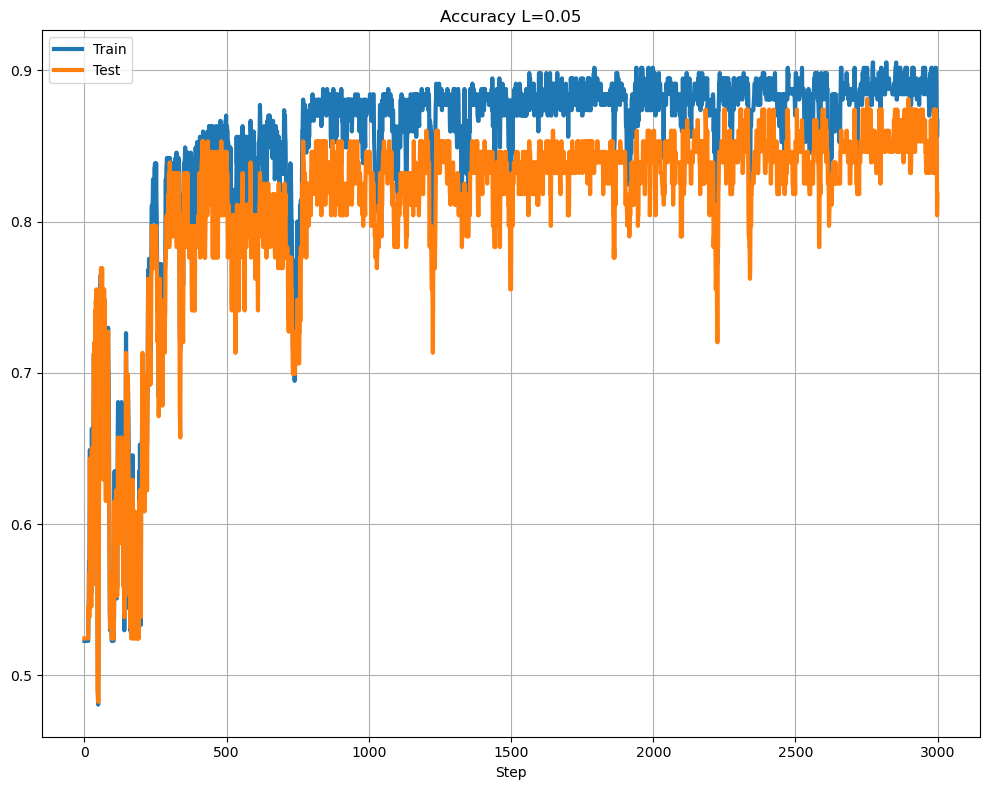

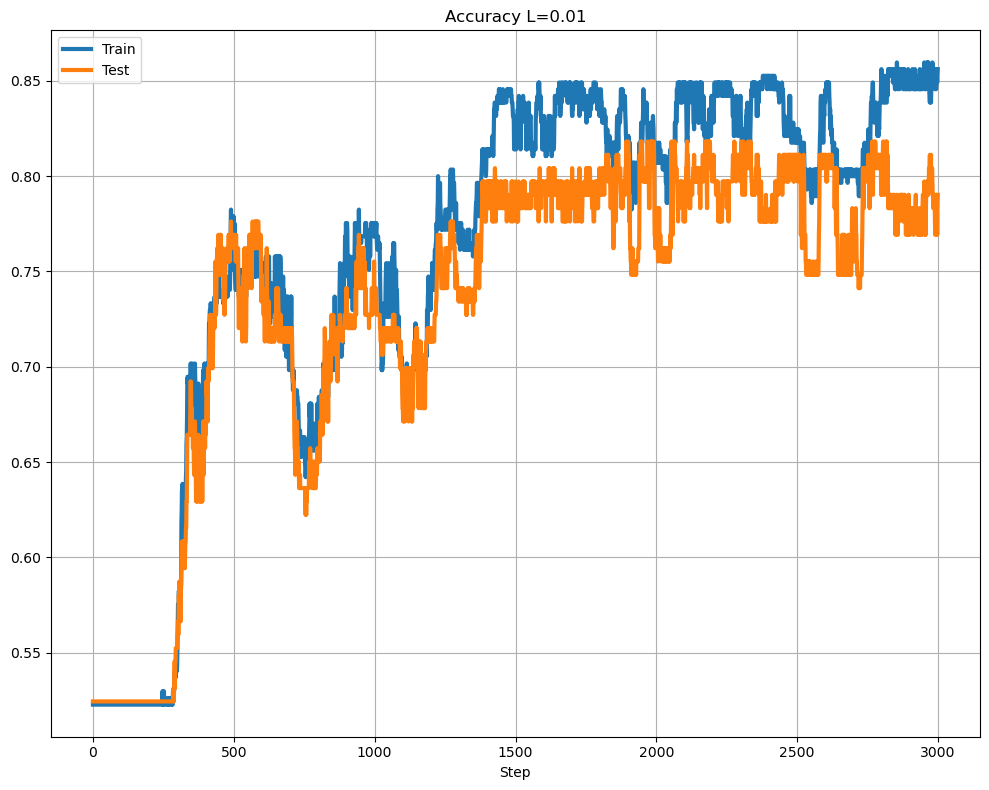

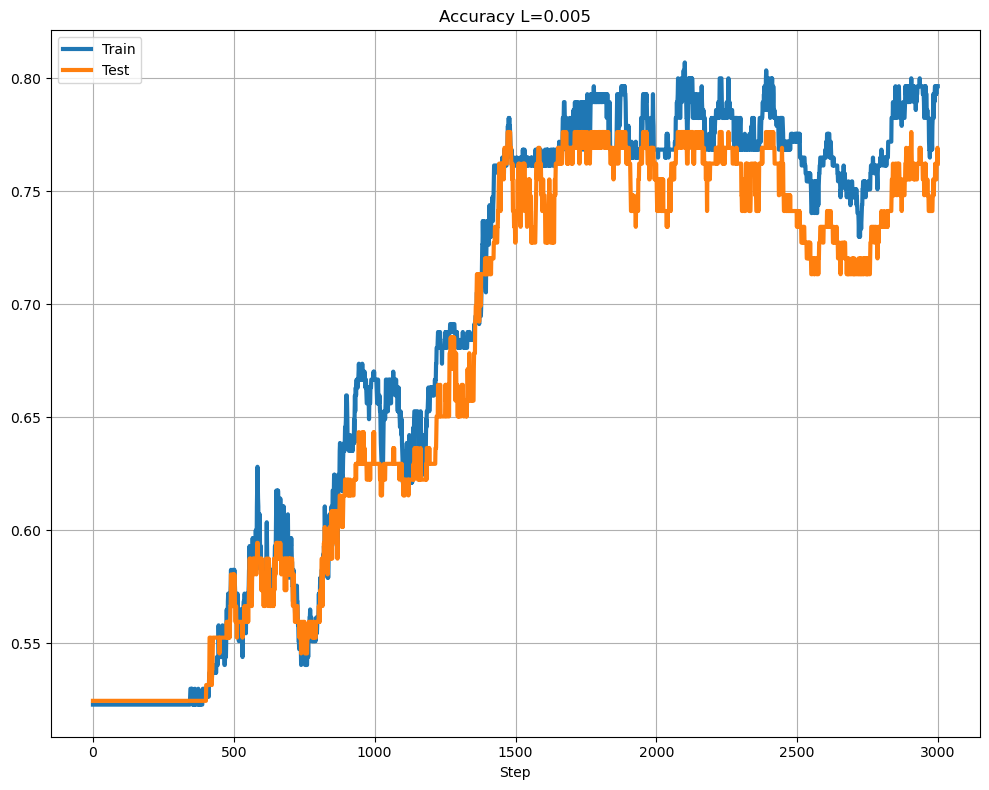

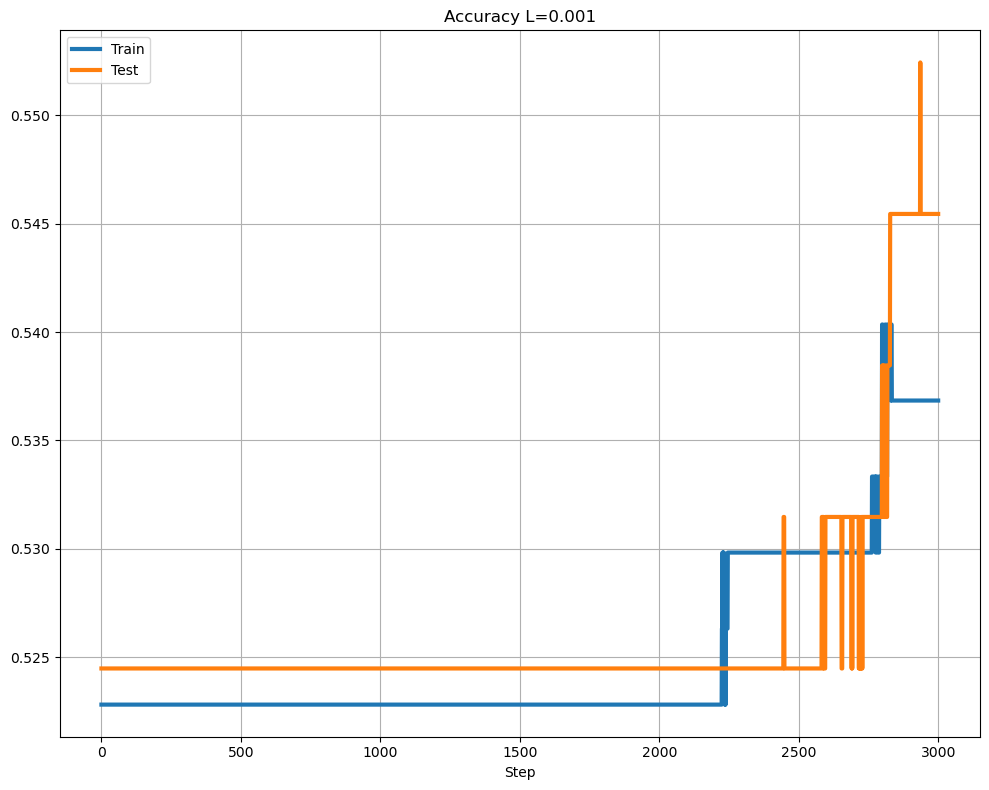

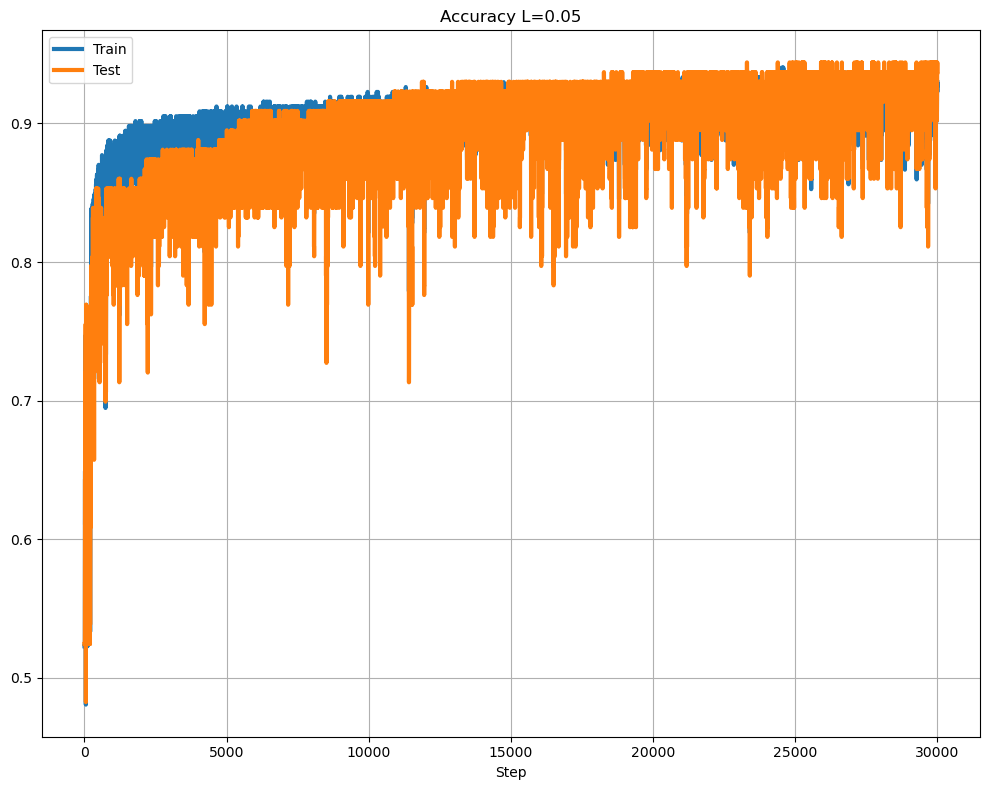

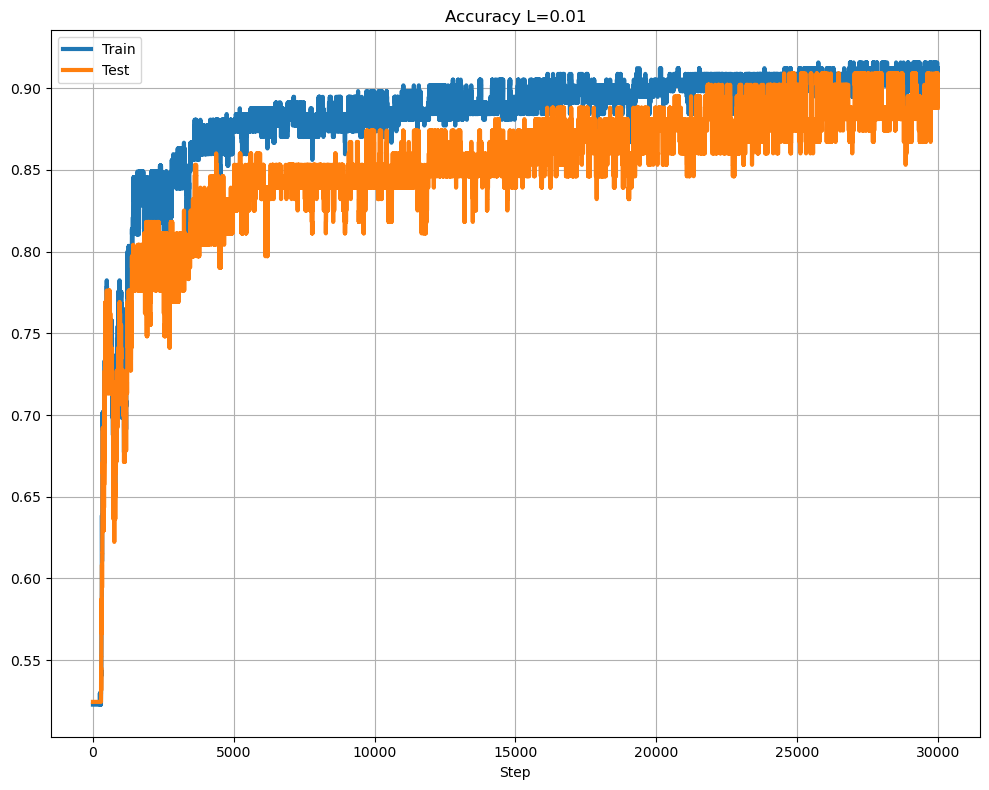

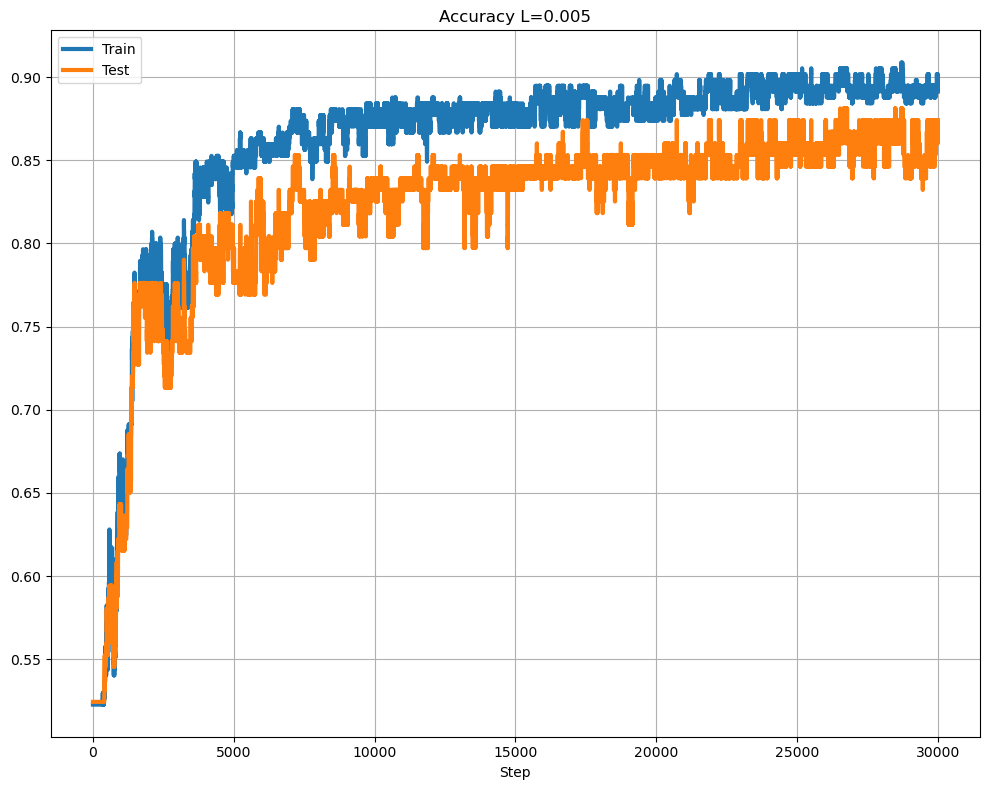

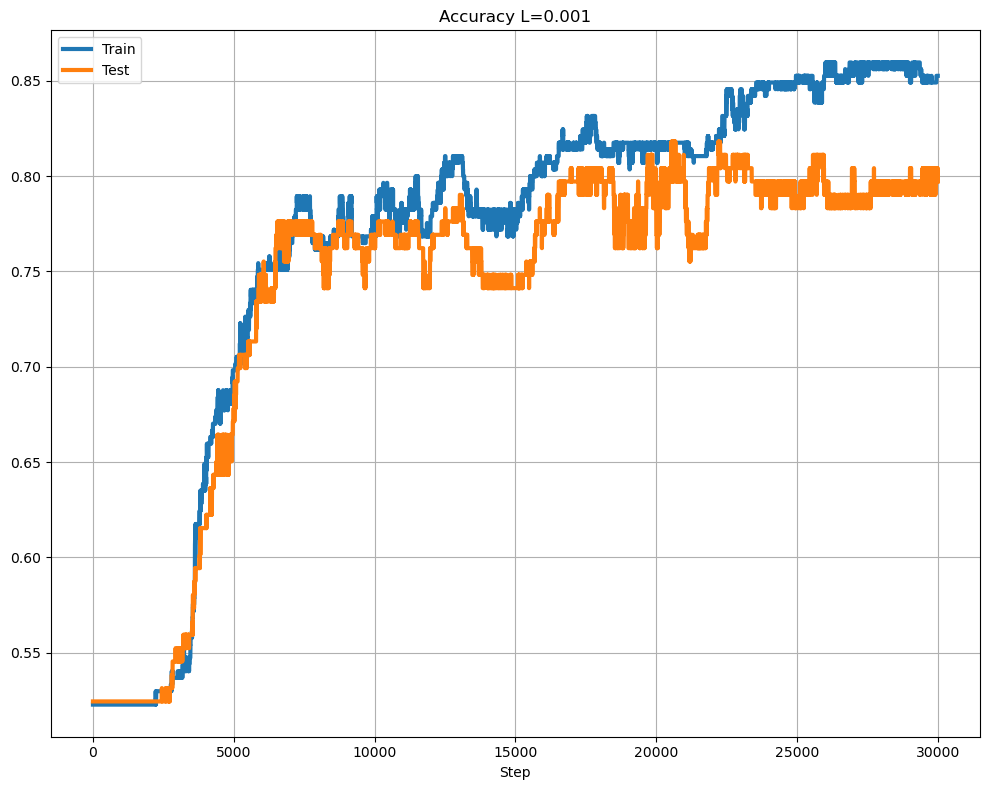

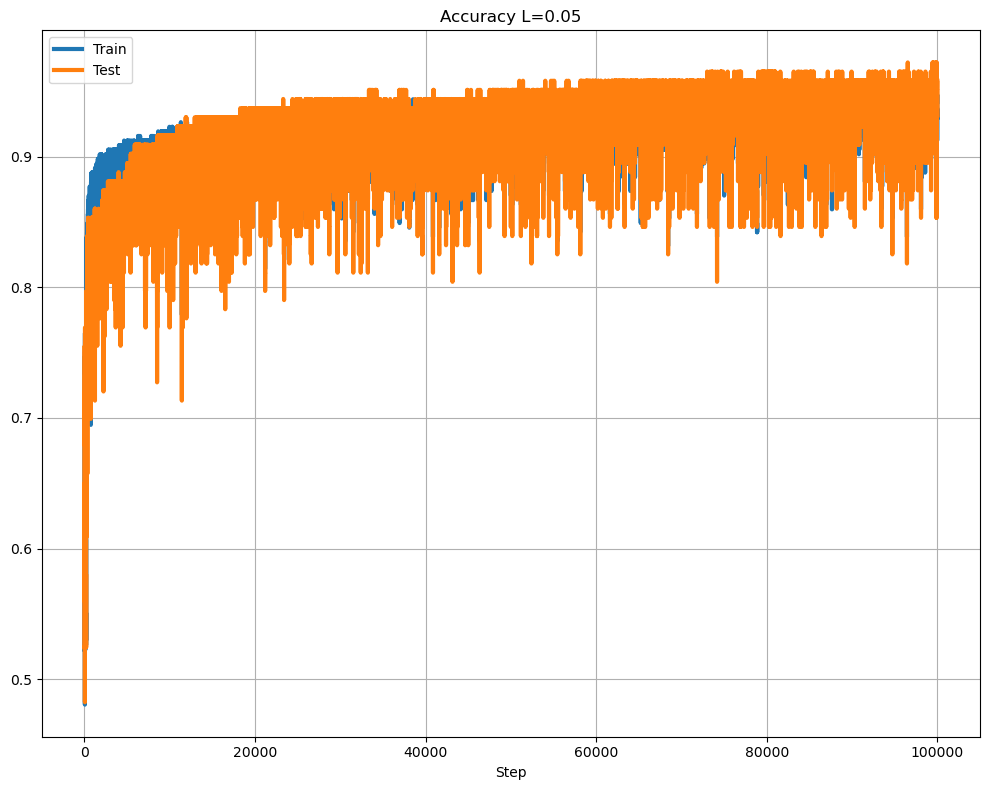

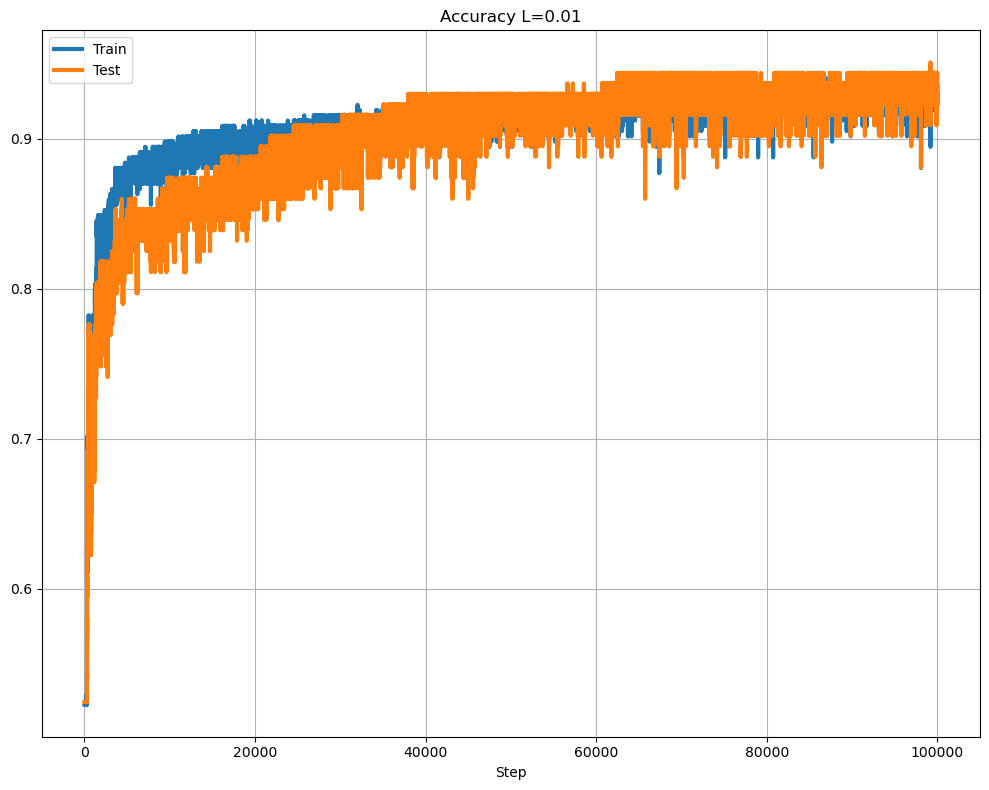

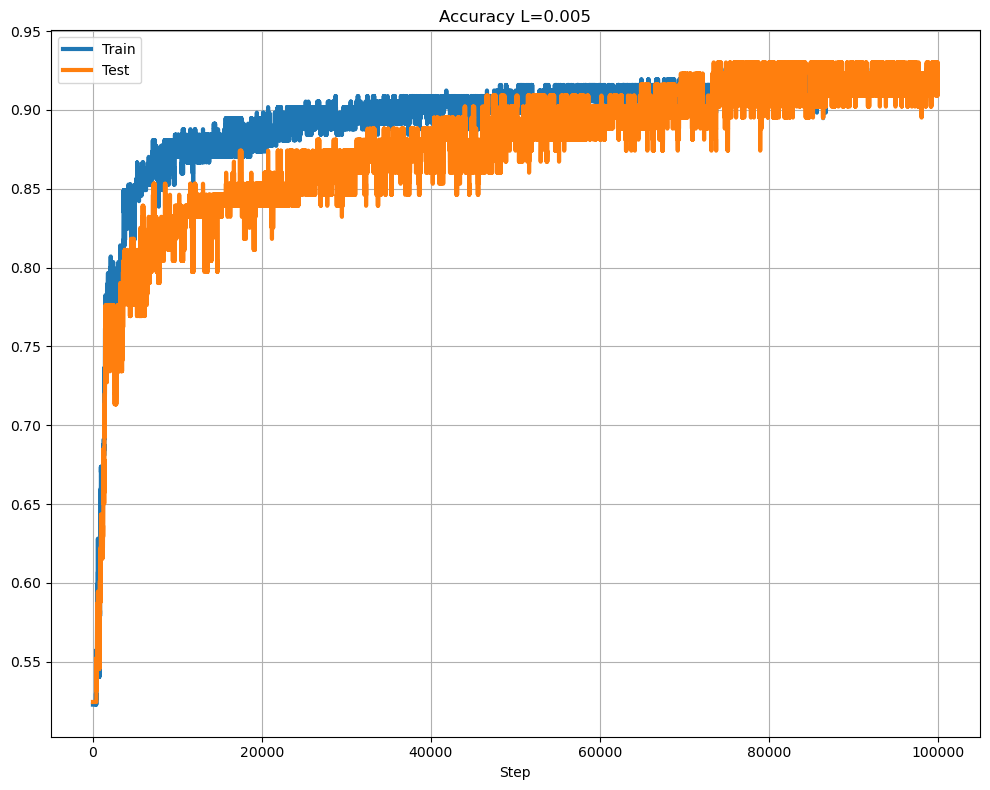

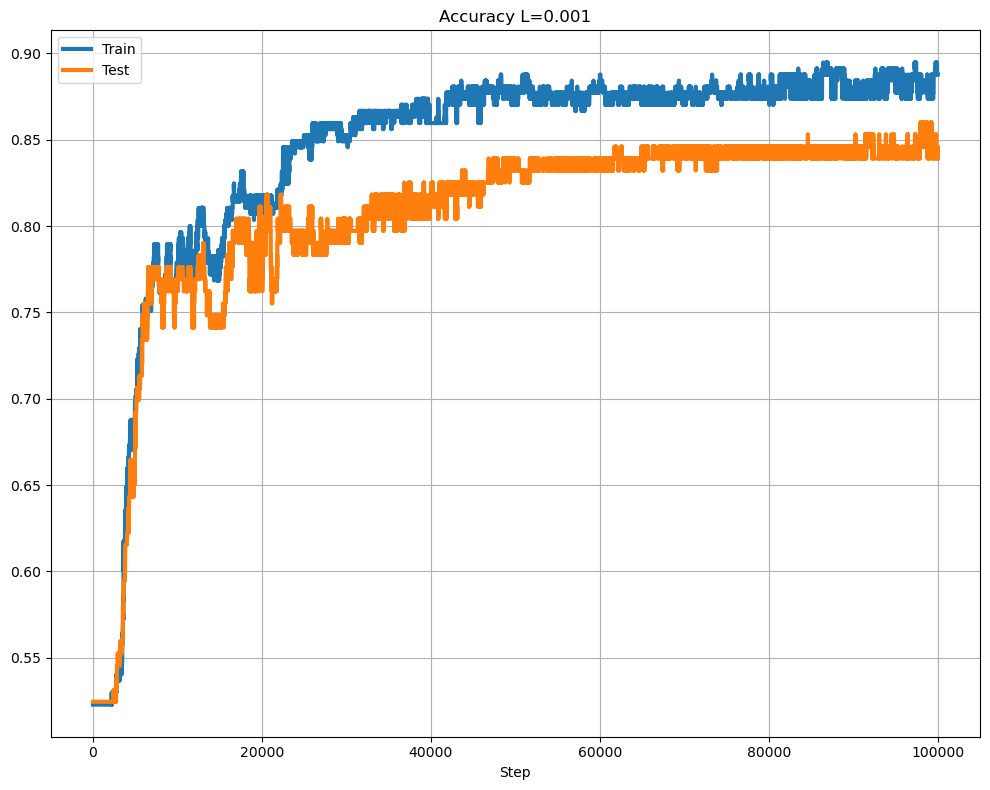

In [31]:
iters_l = (300,3000,30000,100_000)
L_l = (0.05, 0.01, 0.005, 0.001)

for iter in iters_l:
    for L in L_l:
        mi_red_neuronal(L=L, iteraciones = iter)
        print()